Import av nødvendige moduler

In [1]:
import sys
src_path = "..\\src"
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from pandasql import sqldf


import functions as fc

Hente inn og forberede data

referansetid er gjort om til DateTime
Den minste verdien er: 0.0
Den høyeste verdien er: 47.0


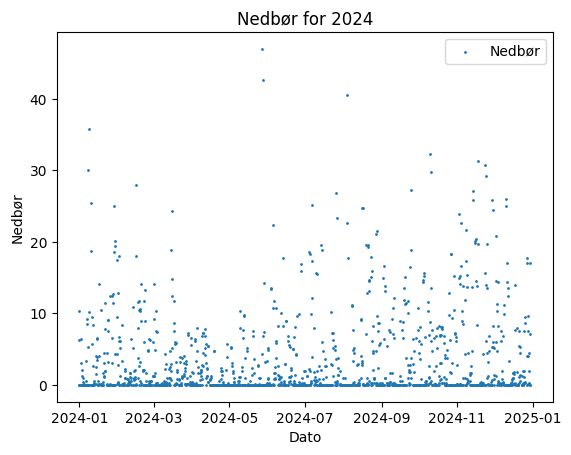

In [ ]:
# Hente inn datasett fra data
precipitation = pd.read_csv("../data/precipitation.csv")

# Sjekker hvor mange av verdiene som mangler
fc.missing_numbers(precipitation)

# Endre tidshenvisning til datetime-format
date = fc.make_datetime(precipitation)

# Printer hva den høyeste og laveste verdien er 
print('Den minste verdien er:', precipitation['verdi'].min())
print('Den høyeste verdien er:', precipitation['verdi'].max())


plt.scatter(date, precipitation['verdi'], label="Nedbør", s=1)
plt.xlabel('Dato') 
plt.ylabel('Nedbør') 
plt.title('Nedbør for 2024') 
plt.legend()
plt.show()

Introdusere feil i datasettet

In [3]:
# Lagrer de linjene i precipitation det går utover
np.random.seed(123)

# Sier jeg vil ha 5 verdier og at de skal velges ut ifra lengden på precipitation
numExtreme = 5
mod_indices = np.random.choice(len(precipitation), numExtreme, replace=False)

print(mod_indices)

# Velger så 5 verdier mellom 15 og 19 
extreme_value = np.random.randint(15, 20, len(mod_indices))
print(extreme_value)

# Så ganger jeg de valgte verdiene i precipitation med extreme_values
precipitation.loc[mod_indices, 'verdi'] *= extreme_value

# Printer hva den høyeste og laveste verdien er 
print('Den minste verdien er:', precipitation['verdi'].min())
print('Den høyeste verdien er:', precipitation['verdi'].max())


[ 147  676 1304 1372 1427]
[15 19 15 16 19]
Den minste verdien er: 0.0
Den høyeste verdien er: 222.4


Visualisere resultater fra datasett med feil

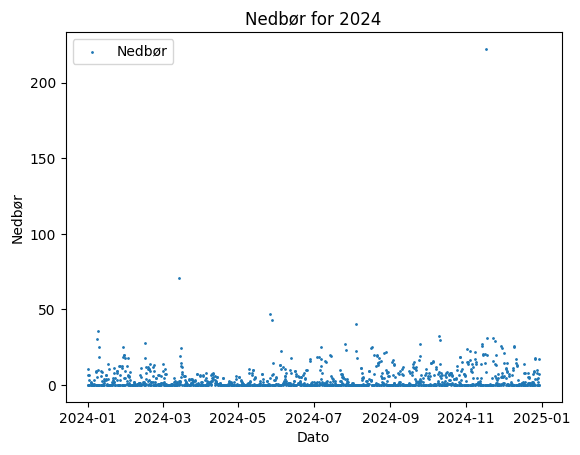

" # Regne ut gjennomsnittlig nedbør over tid\nfc.average_year(precipitation)\nmonthly_prcp = fc.average_other(precipitation)\n\n# Regne ut median\nfc.median(precipitation)\n\n# Visualisere månedlig gjennomsnitt\nfc.average_month_bargraph(monthly_prcp, 'Nedbør', 'mm') "

In [4]:
# Visualiserer datasettet med extreme verdier
plt.scatter(date, precipitation['verdi'], label="Nedbør", s=1)
plt.xlabel('Dato') 
plt.ylabel('Nedbør') 
plt.title('Nedbør for 2024') 
plt.legend()
plt.show()


""" # Regne ut gjennomsnittlig nedbør over tid
fc.average_year(precipitation)
monthly_prcp = fc.average_other(precipitation)

# Regne ut median
fc.median(precipitation)

# Visualisere månedlig gjennomsnitt
fc.average_month_bargraph(monthly_prcp, 'Nedbør', 'mm') """

Skille ut ektreme verdier

Gjennomsnittlig verdi for datasettet er 3.47
Standardavviket er 8.38
      Unnamed: 0  verdi tidsforskyvning              referansetid
147          147   70.5            PT6H 2024-03-14 00:00:00+00:00
294          294   47.0           PT18H 2024-05-27 00:00:00+00:00
297          297   42.7            PT6H 2024-05-28 00:00:00+00:00
432          432   40.5           PT18H 2024-08-04 00:00:00+00:00
566          566   32.3           PT18H 2024-10-10 00:00:00+00:00
569          569   29.8            PT6H 2024-10-11 00:00:00+00:00
744          744   30.1           PT18H 2024-01-08 00:00:00+00:00
747          747   35.8            PT6H 2024-01-09 00:00:00+00:00
1372        1372  222.4           PT18H 2024-11-17 00:00:00+00:00
1375        1375   31.3            PT6H 2024-11-18 00:00:00+00:00
1384        1384   30.8           PT18H 2024-11-23 00:00:00+00:00
1387        1387   29.2            PT6H 2024-11-24 00:00:00+00:00


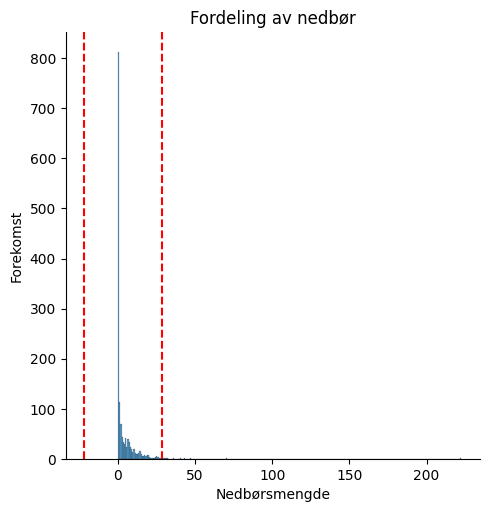

In [5]:
# Finner øvre og nedre grense
lower_limit, upper_limit = fc.lower_upper_limit(precipitation)

# Sier at de verdiene som er utenfor grensene lagres i outliers
outliers = precipitation[precipitation['verdi'].between(lower_limit, upper_limit) == False]
print(outliers) 

# Visualiserer datasettet med øvre og nedre grense 
plot = sns.displot(data=precipitation['verdi']).set(title="Fordeling av nedbør", xlabel="Nedbørsmengde", ylabel='Forekomst')
for ax in plot.axes.flat:
    ax.axvline(lower_limit, color='r', linestyle='--', label='Lower Limit')
    ax.axvline(upper_limit, color='r', linestyle='--', label='Upper Limit')


Fjerne ekstreme verdier

[70.5, 47.0, 42.7, 40.5, 32.3, 29.8, 30.1, 35.8, 222.4, 31.3, 30.8, 29.2]
Den minste verdien er: 0.0
Den høyeste verdien er: 28.0


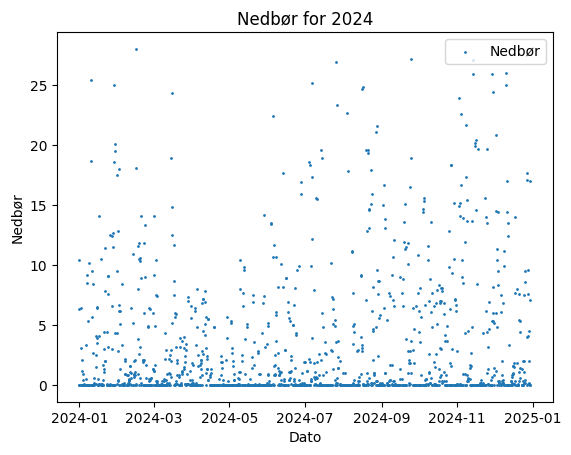

In [6]:
# Alle verdiene som er utenfor standardavviket legges i lista remove
remove = []
for i in outliers['verdi']:
    remove.append(i)
print(remove)

# Verdiene i precipitation som er lik verdiene i remove byttes ut med NaN
precipitation['verdi'] = precipitation['verdi'].replace(remove, np.nan)

# print den laveste og høyeste verdien for å vise at verdiene har endret seg
print('Den minste verdien er:', precipitation['verdi'].min())
print('Den høyeste verdien er:', precipitation['verdi'].max())

# Visualiserer datasettet uten ekstreme verdier
plt.scatter(date, precipitation['verdi'], label="Nedbør", s=1)
plt.xlabel('Dato') 
plt.ylabel('Nedbør') 
plt.title('Nedbør for 2024') 
plt.legend()
plt.show()


Få oversikt over manglende verdier i datasettet

Unnamed: 0          0
verdi              12
tidsforskyvning     0
referansetid        0
dtype: int64
      Unnamed: 0  verdi tidsforskyvning              referansetid
147          147    NaN            PT6H 2024-03-14 00:00:00+00:00
294          294    NaN           PT18H 2024-05-27 00:00:00+00:00
297          297    NaN            PT6H 2024-05-28 00:00:00+00:00
432          432    NaN           PT18H 2024-08-04 00:00:00+00:00
566          566    NaN           PT18H 2024-10-10 00:00:00+00:00
569          569    NaN            PT6H 2024-10-11 00:00:00+00:00
744          744    NaN           PT18H 2024-01-08 00:00:00+00:00
747          747    NaN            PT6H 2024-01-09 00:00:00+00:00
1372        1372    NaN           PT18H 2024-11-17 00:00:00+00:00
1375        1375    NaN            PT6H 2024-11-18 00:00:00+00:00
1384        1384    NaN           PT18H 2024-11-23 00:00:00+00:00
1387        1387    NaN            PT6H 2024-11-24 00:00:00+00:00


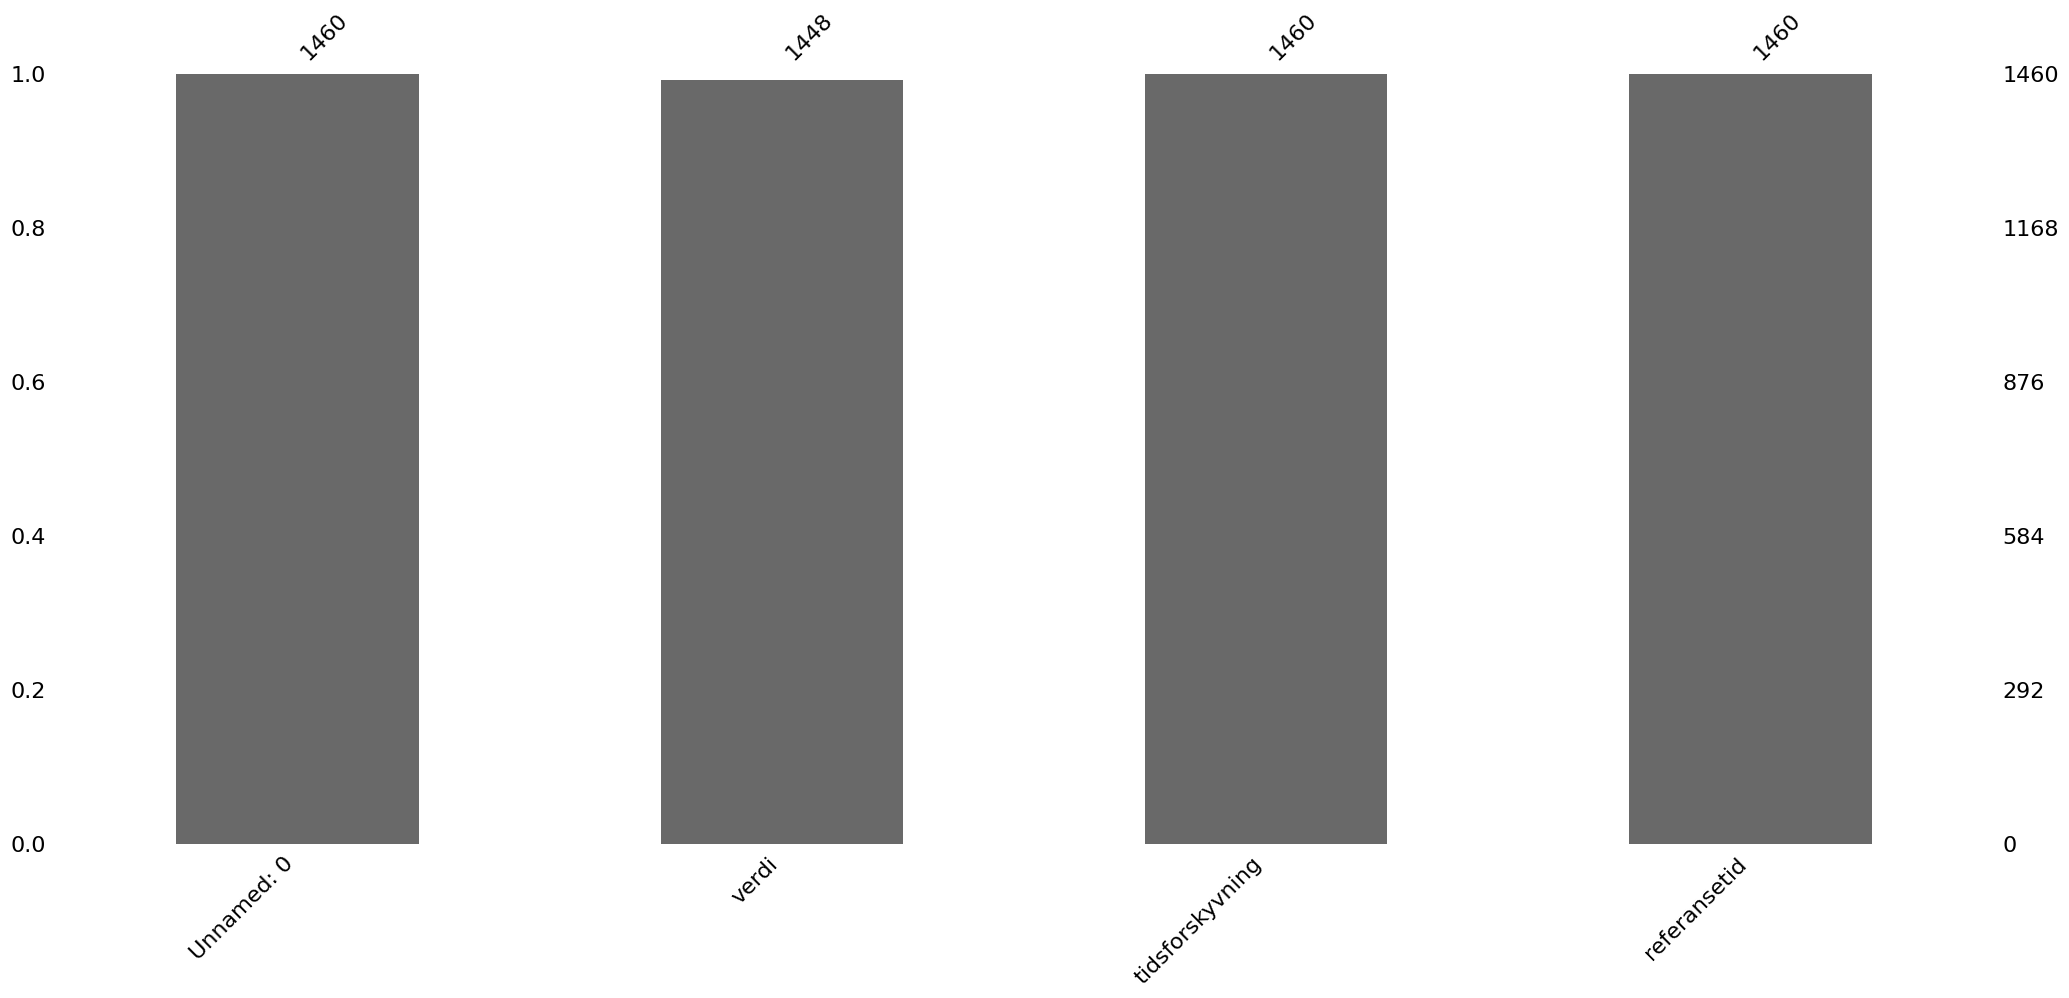

In [7]:
# Sjekker hvor mange og hvilke av verdiene som mangler
fc.missing_numbers(precipitation)

Fylle inn manglende verdier i datasettet

C:\Users\runa_\AppData\Local\Temp\ipykernel_21420\3173948981.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  add_data = precipitation['verdi'].fillna(method='ffill', inplace=True)
C:\Users\runa_\AppData\Local\Temp\ipykernel_21420\3173948981.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  add_data = precipitation['verdi'].fillna(method='ffill', inplace=True)


Unnamed: 0         0
verdi              0
tidsforskyvning    0
referansetid       0
dtype: int64
Empty DataFrame
Columns: [Unnamed: 0, verdi, tidsforskyvning, referansetid]
Index: []


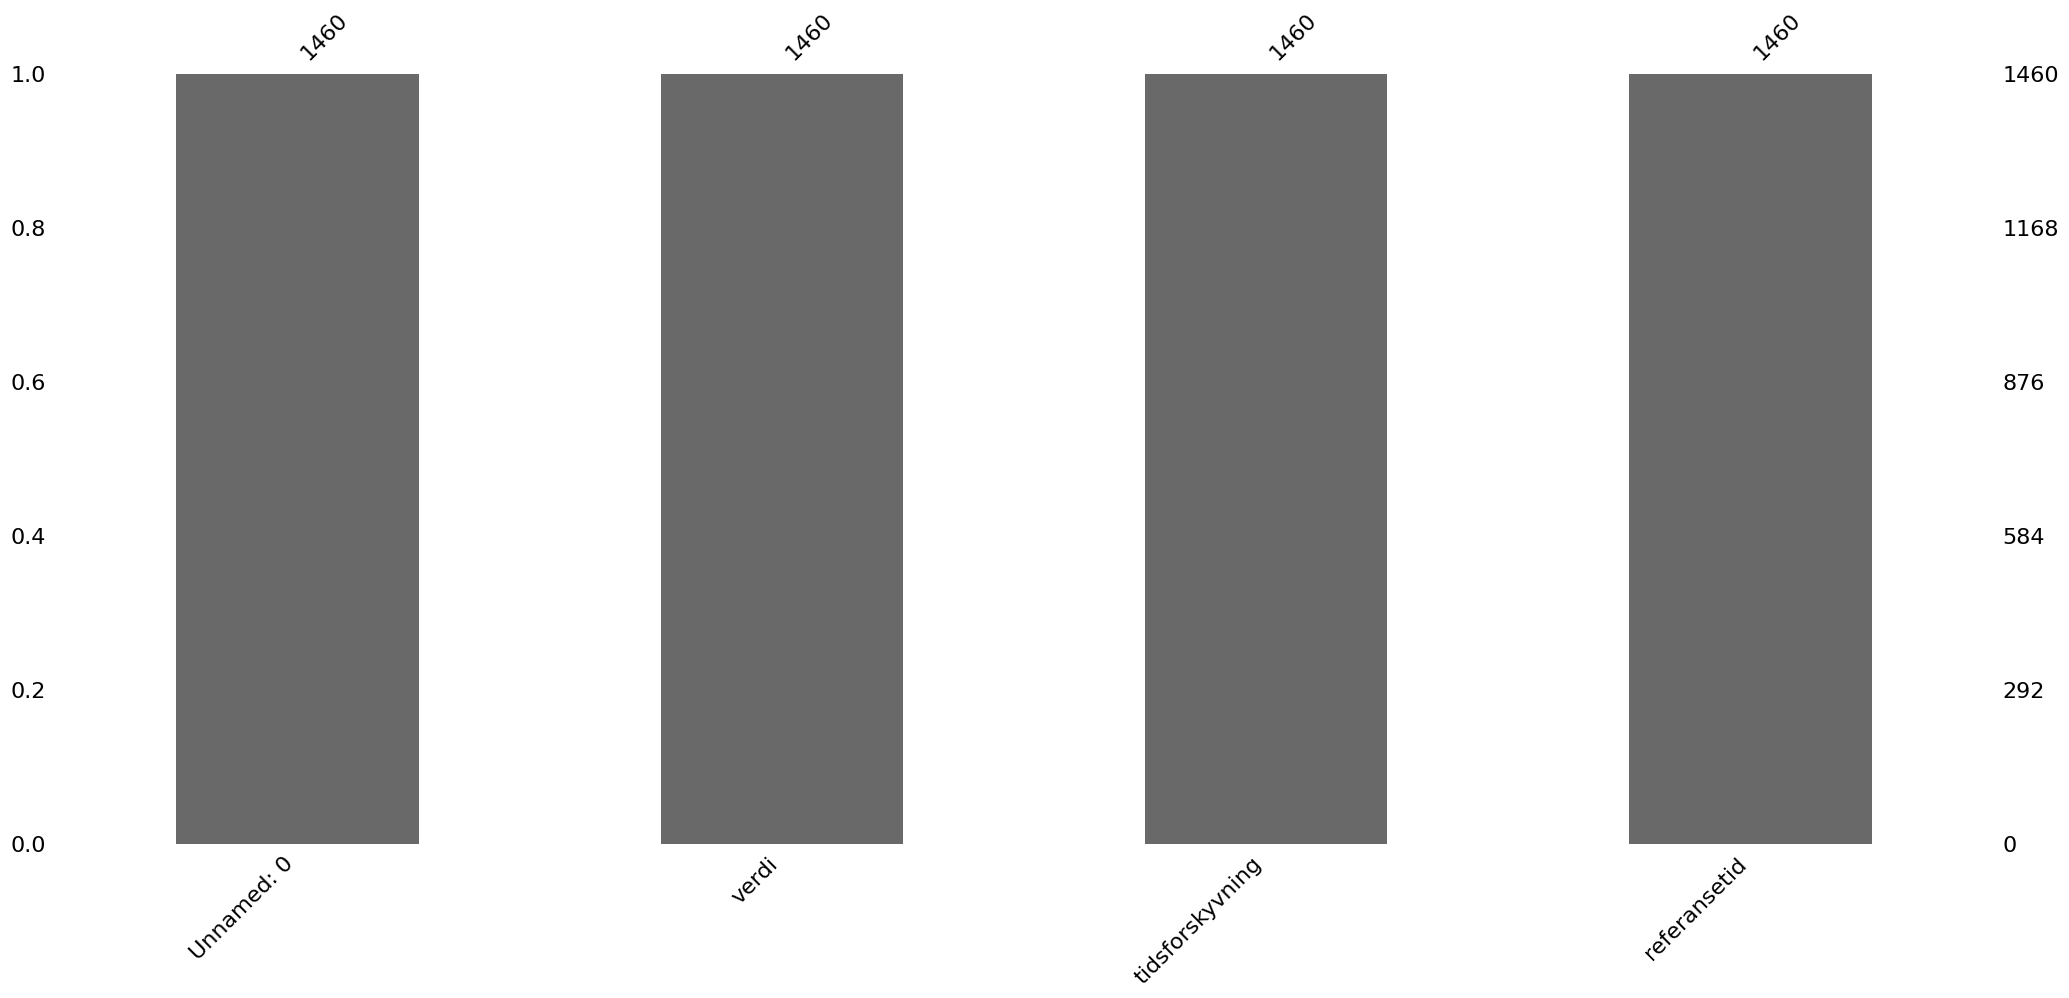

In [8]:
# Gjør NaN om til neste verdi i fila 
add_data = precipitation['verdi'].fillna(method='ffill', inplace=True)

# Sjekker at verdiene er fylt inn
fc.missing_numbers(precipitation)

Testkode

In [9]:
print(precipitation)

      Unnamed: 0  verdi tidsforskyvning              referansetid
0              0   10.4           PT18H 2024-01-01 00:00:00+00:00
1              1    6.3            PT6H 2024-01-01 00:00:00+00:00
2              2    3.1           PT18H 2024-01-02 00:00:00+00:00
3              3    6.4            PT6H 2024-01-02 00:00:00+00:00
4              4    1.2           PT18H 2024-01-03 00:00:00+00:00
...          ...    ...             ...                       ...
1455        1455    9.6            PT6H 2024-12-28 00:00:00+00:00
1456        1456    2.0           PT18H 2024-12-29 00:00:00+00:00
1457        1457    4.5            PT6H 2024-12-29 00:00:00+00:00
1458        1458   17.0           PT18H 2024-12-30 00:00:00+00:00
1459        1459    7.1            PT6H 2024-12-30 00:00:00+00:00

[1460 rows x 4 columns]


Counter({Timestamp('2024-01-01 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-02 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-03 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-04 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-05 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-06 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-07 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-08 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-09 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-10 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-11 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-12 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-13 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-14 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-15 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-16 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-17 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-18 00:00:00+0000', tz='UTC'): 4, Timestamp('2024-01-19 00:00:00+0000', tz='UTC'): 4, Tim

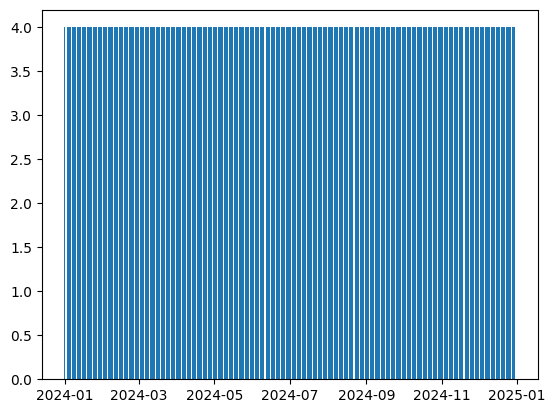

In [10]:
# Teller hvor mange ganger hver dato skjer i temperatur tabellen.
days = Counter(precipitation['referansetid'])
print(days)

# Finner ut om det er noen datoer som har flere verdier enn andre.
for i in days:
    if days[i] != 4:
        print (i)

# Viser visuelt om det er noen datoer som har flere verdier enn andre.
plt.bar(days.keys(), days.values())



# Visualiserer de ulike tidsforskyvningene
fig = px.scatter(precipitation, 
                x= 'referansetid', 
                y= 'verdi',
                color= 'tidsforskyvning', 
                trendline= 'ols',
                trendline_scope='trace'
                )

fig.update_layout(title=dict(text='Precipitation')
)
fig.show()


# Finner gjennomsnittet for hver av tidsforskyvningene
#fc.average_other(precipitation)